In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
from torch.optim import SGD
from timeit import default_timer as timer
#from sklearn.metrics import confusion_matrix
#import seaborn as sn
#import pandas as pd
#from pretty_confusion_matrix import pp_matrix
#from pretty_confusion_matrix import pp_matrix_from_data

Download and load the training data

In [2]:
train_set = datasets.MNIST('data/', download=True, train=True)
train_images = train_set.data
train_targets = train_set.targets

In [3]:
test_set = datasets.MNIST('data/', download=True, train=False)
test_images = test_set.data
test_targets = test_set.targets

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [5]:
def get_data():
    train = MNISTDataset(train_images, train_targets)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test = MNISTDataset(test_images, test_targets)
    test_dl = DataLoader(test, batch_size=len(test_images), shuffle=True)
    return train_dl, test_dl

In [6]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 70),
        nn.Sigmoid(),
        nn.Linear(70, 35),
        nn.Sigmoid(),
        nn.Linear(35, 15),
        nn.Sigmoid(),
        nn.Linear(15, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=15e-2)
    return model, loss_fn, optimizer

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
@torch.no_grad()
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
@torch.no_grad()
def loss(x, y, model):
    prediction = model(x)
    loss = loss_fn(prediction, y)
    return loss.item()

In [10]:
train_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

In [11]:
# ----------------------------------------------
# Test >>>
#
#model.load_state_dict(torch.load("nnMnist_40h_20h.ph", map_location='cpu'))

#y_pred = []
#y_true = []

#for data, target in test_dl:
#    data, target = data.to(device), target.to(device)
#    output = model(data)
#    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
#    y_pred.extend(pred.data.cpu().numpy())
#    y_true.extend(target.data.cpu().numpy())

#pp_matrix_from_data(y_true, y_pred, cmap='viridis')

In [12]:
## ----------------------------------------------
## Training >>>
##

print('Starting training...')

time0 = timer()

epochs = 40

arrPlotX = []
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
for epoch in range(epochs):
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    arrPlotX.append(epoch)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_losses.append(validation_loss)
    test_accuracies.append(val_epoch_accuracy)
    print( f"epoch: {epoch}  train_acc: {100 * train_epoch_accuracy:.2f}%  test_acc: {100 * val_epoch_accuracy:.2f}%" )
    

In [13]:
torch.save(model.state_dict(), "nnMnist_40h_20h.ph")

NameError: name 'arrPlotX' is not defined

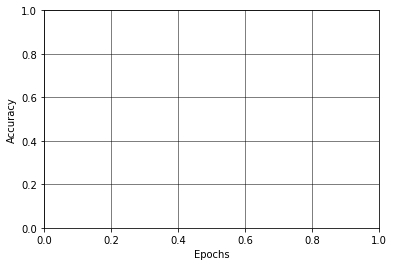

In [14]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.plot(arrPlotX, train_accuracies,"b",label='Training')
# plt.legend()
plt.plot(arrPlotX, test_accuracies,"r", label='Testing')
plt.legend()

plt.savefig("accuracies.png")
